December 5, 2025

##### Changes:

- Validation set (new), Training set much bigger
- tqdm during training
- saved checkpoint

# The Data Pipeline: 3D .nii file -> 2d image -> torch tensors

In [ ]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from old_brats_utils import BraTSSmartDataset

DATA_ROOT = Path("/Users/michaelbanks/Desktop/AI TXG/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")

train_dataset = BraTSSmartDataset(DATA_ROOT, 0, 200)

validation_dataset = BraTSSmartDataset(DATA_ROOT, 200, 300)

test_dataset = BraTSSmartDataset(DATA_ROOT, 300, 369)

Preprocessing: Scanning for slices with tumors...
Success! Found 12628 valid slices containing tumors.
Preprocessing: Scanning for slices with tumors...
Success! Found 6281 valid slices containing tumors.
Preprocessing: Scanning for slices with tumors...
Success! Found 4443 valid slices containing tumors.


In [5]:
# Check slices per patient
for patient_path in train_dataset.patient_folders[:300]:  # Check first 5
    patient_id = patient_path.name
    mask_path = patient_path / f"{patient_id}_seg.nii"
    mask_3d = nib.load(mask_path).get_fdata()
    print(f"{patient_id}: {mask_3d.shape[2]} slices")


slice_counts = []
for patient_path in train_dataset.patient_folders[:300]:
    patient_id = patient_path.name
    mask_path = patient_path / f"{patient_id}_seg.nii"
    mask_3d = nib.load(mask_path).get_fdata()
    slice_counts.append(mask_3d.shape[2])
    
print(f"Min slices: {min(slice_counts)}, Max slices: {max(slice_counts)}, Mode: {np.bincount(slice_counts).argmax()}")

BraTS20_Training_001: 155 slices
BraTS20_Training_002: 155 slices
BraTS20_Training_003: 155 slices
BraTS20_Training_004: 155 slices
BraTS20_Training_005: 155 slices
BraTS20_Training_006: 155 slices
BraTS20_Training_007: 155 slices
BraTS20_Training_008: 155 slices
BraTS20_Training_009: 155 slices
BraTS20_Training_010: 155 slices
BraTS20_Training_011: 155 slices
BraTS20_Training_012: 155 slices
BraTS20_Training_013: 155 slices
BraTS20_Training_014: 155 slices
BraTS20_Training_015: 155 slices
BraTS20_Training_016: 155 slices
BraTS20_Training_017: 155 slices
BraTS20_Training_018: 155 slices
BraTS20_Training_019: 155 slices
BraTS20_Training_020: 155 slices
BraTS20_Training_021: 155 slices
BraTS20_Training_022: 155 slices
BraTS20_Training_023: 155 slices
BraTS20_Training_024: 155 slices
BraTS20_Training_025: 155 slices
BraTS20_Training_026: 155 slices
BraTS20_Training_027: 155 slices
BraTS20_Training_028: 155 slices
BraTS20_Training_029: 155 slices
BraTS20_Training_030: 155 slices
BraTS20_Tr

##### Quick Data Visualization

Image Shape: torch.Size([1, 240, 240])
Mask Shape: torch.Size([1, 240, 240])


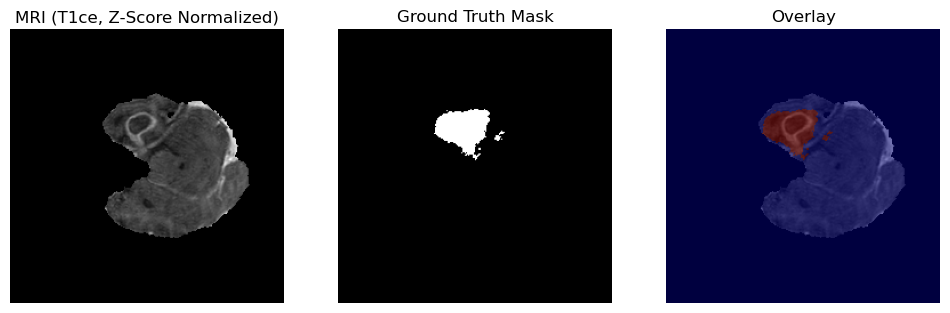

In [4]:
if len(train_dataset) > 0:
    sample_img, sample_mask = train_dataset[16] 

    print(f"Image Shape: {sample_img.shape}") 
    print(f"Mask Shape: {sample_mask.shape}")

    def visualize_overlay(img_tensor, mask_tensor):
        img = img_tensor.squeeze().numpy()
        mask = mask_tensor.squeeze().numpy()
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title("MRI (T1ce, Z-Score Normalized)")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(mask, cmap='jet', alpha=0.5) 
        plt.title("Overlay")
        plt.axis('off')
        
        plt.show()

    visualize_overlay(sample_img, sample_mask)
else:
    print("ERROR: Dataset is empty. Please check the data path.")

##### The DataLoader

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

batch_imgs, batch_masks = next(iter(train_dataloader))
batch_imgs, batch_masks = next(iter(validation_dataloader))

print(f"Batch of Images Shape: {batch_imgs.shape}") 
print(f"Batch of Masks Shape:  {batch_masks.shape}")
# Expected: (16, 1, 240, 240) -> (Batch, Channel, Height, Width)

Batch of Images Shape: torch.Size([16, 1, 240, 240])
Batch of Masks Shape:  torch.Size([16, 1, 240, 240])


# The Model: U-NET

In [6]:
import torch.nn as nn

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, 2) # 240 -> 120
        
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, 2) # 120 -> 60
        
        self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool3 = nn.MaxPool2d(2, 2) # 60 -> 30

        self.bottleneck = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) 
        self.dec3 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU()) 

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) 
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU()) 

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) 
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU()) 

        self.final = nn.Conv2d(16, 1, kernel_size=1) 
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        b = self.bottleneck(self.pool3(e3))
        
        d3 = self.up3(b)
        d3 = torch.cat((e3, d3), dim=1) 
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1) 
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1) 
        d1 = self.dec1(d1)
        
        return self.sigmoid(self.final(d1))

##### Quick Shape Check

In [7]:
model = SimpleUNet()

predictions = model(batch_imgs).detach()

print(f"Input Shape:      {batch_imgs.shape}")
print(f"Prediction Shape: {predictions.shape}")

assert predictions.shape == batch_masks.shape
print("SUCCESS: The model output matches the mask shape. Ready to train!")

Input Shape:      torch.Size([16, 1, 240, 240])
Prediction Shape: torch.Size([16, 1, 240, 240])
SUCCESS: The model output matches the mask shape. Ready to train!


##### Set up Device, Loss, and Optimizer

In [8]:
import torch.optim as optim

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Success: Using Apple Metal (MPS) Acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Success: Using NVIDIA (CUDA) Acceleration!")
else:
    device = torch.device("cpu")
    print("Using CPU (Slower, but works)")

model = model.to(device)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        intersection = torch.sum(predictions * targets)
        union = torch.sum(predictions) + torch.sum(targets)
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1.0 - dice

criterion = DiceLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

Success: Using Apple Metal (MPS) Acceleration!


# The Training Loop

In [11]:
from tqdm.auto import tqdm

num_epochs = 10
history = [] 

print("Starting Training...")

for epoch in range(num_epochs):
    model.train() 
    train_running_loss = 0.0
    
    for i, (images, masks) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()             
        
        outputs = model(images)           
        loss = criterion(outputs, masks)  
        
        loss.backward()                   
        optimizer.step()                  
        
        train_running_loss += loss.item()
    
    train_epoch_loss = train_running_loss / len(train_dataloader)
    history.append(train_epoch_loss)

    print(f"Train Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_epoch_loss:.4f}")


    validation_running_loss = 0.0
    model.eval()
    for i, (images, masks) in tqdm(enumerate(validation_dataloader), total=len(validation_dataloader)):
        
        images = images.to(device)
        masks = masks.to(device)             
        
        outputs = model(images)           
        loss = criterion(outputs, masks)                
        
        validation_running_loss += loss.item()
    
    validation_epoch_loss = validation_running_loss / len(validation_dataloader)
    history.append(validation_epoch_loss)
    
    print(f"Validation Epoch [{epoch+1}/{num_epochs}], Validation Loss: {validation_epoch_loss:.4f}")

print("Training Finished!")
m3Checkpoint = torch.save(model.state_dict(), 'model3_checkpoint.pth') 
o3Checkpoint = torch.save(optimizer.state_dict(), 'optimizer3_checkpoint.pth')

Starting Training...


  0%|          | 0/790 [00:00<?, ?it/s]

Train Epoch [1/10], Training Loss: 0.3299


  0%|          | 0/393 [00:00<?, ?it/s]

Validation Epoch [1/10], Validation Loss: 0.5875


  0%|          | 0/790 [00:00<?, ?it/s]

Train Epoch [2/10], Training Loss: 0.2648


  0%|          | 0/393 [00:00<?, ?it/s]

Validation Epoch [2/10], Validation Loss: 0.5493


  0%|          | 0/790 [00:00<?, ?it/s]

Train Epoch [3/10], Training Loss: 0.2328


  0%|          | 0/393 [00:00<?, ?it/s]

Validation Epoch [3/10], Validation Loss: 0.5242


  0%|          | 0/790 [00:00<?, ?it/s]

Train Epoch [4/10], Training Loss: 0.2180


  0%|          | 0/393 [00:00<?, ?it/s]

Validation Epoch [4/10], Validation Loss: 0.5227


  0%|          | 0/790 [00:00<?, ?it/s]

Train Epoch [5/10], Training Loss: 0.2003


  0%|          | 0/393 [00:00<?, ?it/s]

Validation Epoch [5/10], Validation Loss: 0.5164


  0%|          | 0/790 [00:00<?, ?it/s]

Train Epoch [6/10], Training Loss: 0.1902


  0%|          | 0/393 [00:00<?, ?it/s]

Validation Epoch [6/10], Validation Loss: 0.4973


  0%|          | 0/790 [00:00<?, ?it/s]

Train Epoch [7/10], Training Loss: 0.1799


  0%|          | 0/393 [00:00<?, ?it/s]

Validation Epoch [7/10], Validation Loss: 0.4840


  0%|          | 0/790 [00:00<?, ?it/s]

Train Epoch [8/10], Training Loss: 0.1713


  0%|          | 0/393 [00:00<?, ?it/s]

Validation Epoch [8/10], Validation Loss: 0.4899


  0%|          | 0/790 [00:00<?, ?it/s]

Train Epoch [9/10], Training Loss: 0.1647


  0%|          | 0/393 [00:00<?, ?it/s]

Validation Epoch [9/10], Validation Loss: 0.4712


  0%|          | 0/790 [00:00<?, ?it/s]

Train Epoch [10/10], Training Loss: 0.1595


  0%|          | 0/393 [00:00<?, ?it/s]

Validation Epoch [10/10], Validation Loss: 0.4764
Training Finished!


# Validation & Visualization

In [12]:
testModel = SimpleUNet()
testModel.load_state_dict(torch.load('model3_checkpoint.pth'))
testModel = testModel.to(device)

/var/folders/50/phlf5vwd3dn2qt_7m0bpqqth0000gp/T/ipykernel_1899/1123638360.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testModel.load_state_dict(torch.load('model3_c

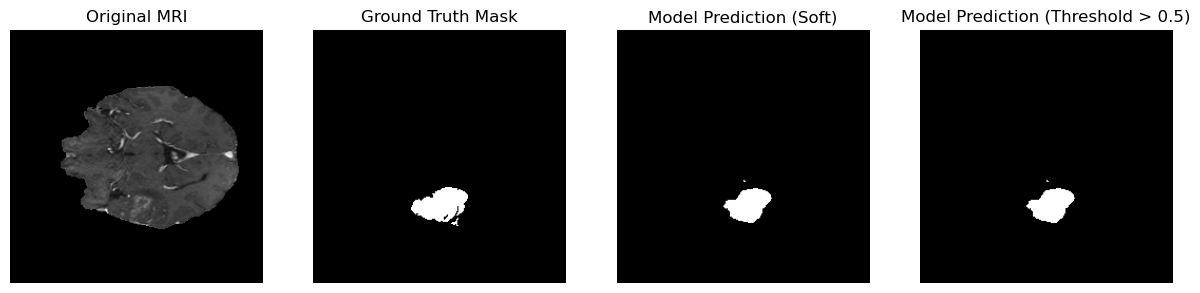

In [30]:
testModel.eval()

test_img, test_mask = test_dataset[743] 

input_tensor = test_img.unsqueeze(0).to(device)

with torch.no_grad(): 
    prediction = testModel(input_tensor)

pred_cpu = prediction.squeeze().cpu().numpy()
pred_thresholded = (pred_cpu > 0.5).astype(float)
img_cpu = test_img.squeeze().numpy()
mask_cpu = test_mask.squeeze().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_cpu, cmap='gray')
plt.title("Original MRI")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask_cpu, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(pred_cpu, cmap='gray')
plt.title("Model Prediction (Soft)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(pred_thresholded, cmap='gray')
plt.title("Model Prediction (Threshold > 0.5)")
plt.axis('off')

plt.show()

# Validation pt.2 

In [17]:
from tqdm.auto import tqdm
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
validation_losses = []
testModel.eval()
for i, (images, masks) in tqdm(enumerate(validation_dataloader), total=len(validation_dataloader)):
    
    images = images.to(device)
    masks = masks.to(device)             
    outputs = testModel(images)           
    loss = criterion(outputs, masks)                
        
    validation_losses.append(loss.item())

  0%|          | 0/6281 [00:00<?, ?it/s]

In [20]:
indicies = np.argsort(validation_losses)[-5:]

In [21]:
print(indicies)

[5597 5598 2805 2918 3140]


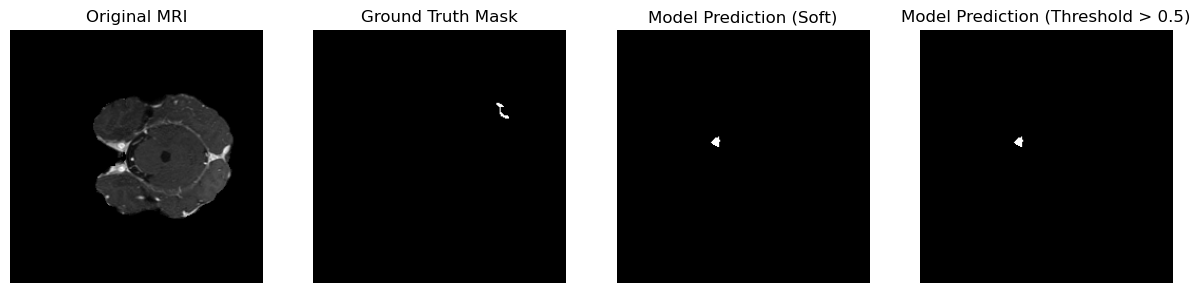

In [34]:
test_img, test_mask = validation_dataset[indicies[4]] 

input_tensor = test_img.unsqueeze(0).to(device)

with torch.no_grad(): 
    prediction = testModel(input_tensor)

pred_cpu = prediction.squeeze().cpu().numpy()
pred_thresholded = (pred_cpu > 0.5).astype(float)
img_cpu = test_img.squeeze().numpy()
mask_cpu = test_mask.squeeze().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_cpu, cmap='gray')
plt.title("Original MRI")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask_cpu, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(pred_cpu, cmap='gray')
plt.title("Model Prediction (Soft)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(pred_thresholded, cmap='gray')
plt.title("Model Prediction (Threshold > 0.5)")
plt.axis('off')

plt.show()

In [27]:
ones = 0
for val in validation_losses:
    if val == 1:
        ones += 1
print(ones)
print(ones/len(validation_losses))

761
0.1211590511065117


# Next Steps: 

- Maybe use test_dataset in training/validation? (dont really need test atm)

- Double check how it performs on images without a tumor (make sure it knows there is no tumor)
    - Create seperate dataset with images with no tumor, load in model test it

- Data augmentations (dont need to train, just get them implemented) - model4

- 3d Model (back to research, figure out how these work, inputs/ouputs) -model5 (rough draft)

### include data with augmentation and no tumors, shoot for much bigger dataset

- look into what are safe augmentations to make that would still actually happen

- different modalities?

- different tumor labels? 